Epoch 01 | train 0.293749 | val 0.201815
Epoch 02 | train 0.186217 | val 0.149118
Epoch 03 | train 0.111165 | val 0.039043
Epoch 04 | train 0.043267 | val 0.020546
Epoch 05 | train 0.025285 | val 0.007755
Epoch 06 | train 0.017459 | val 0.009902
Epoch 07 | train 0.020192 | val 0.002789
Epoch 08 | train 0.013604 | val 0.015522
Epoch 09 | train 0.014540 | val 0.003815
Epoch 10 | train 0.011796 | val 0.007188
Epoch 11 | train 0.010417 | val 0.002681
Epoch 12 | train 0.009180 | val 0.003672
Epoch 13 | train 0.008236 | val 0.001033
Epoch 14 | train 0.007449 | val 0.001865
Epoch 15 | train 0.006591 | val 0.002471
RMSE Train: 0.024384
RMSE Val:   0.024683
RMSE Test:  0.024109


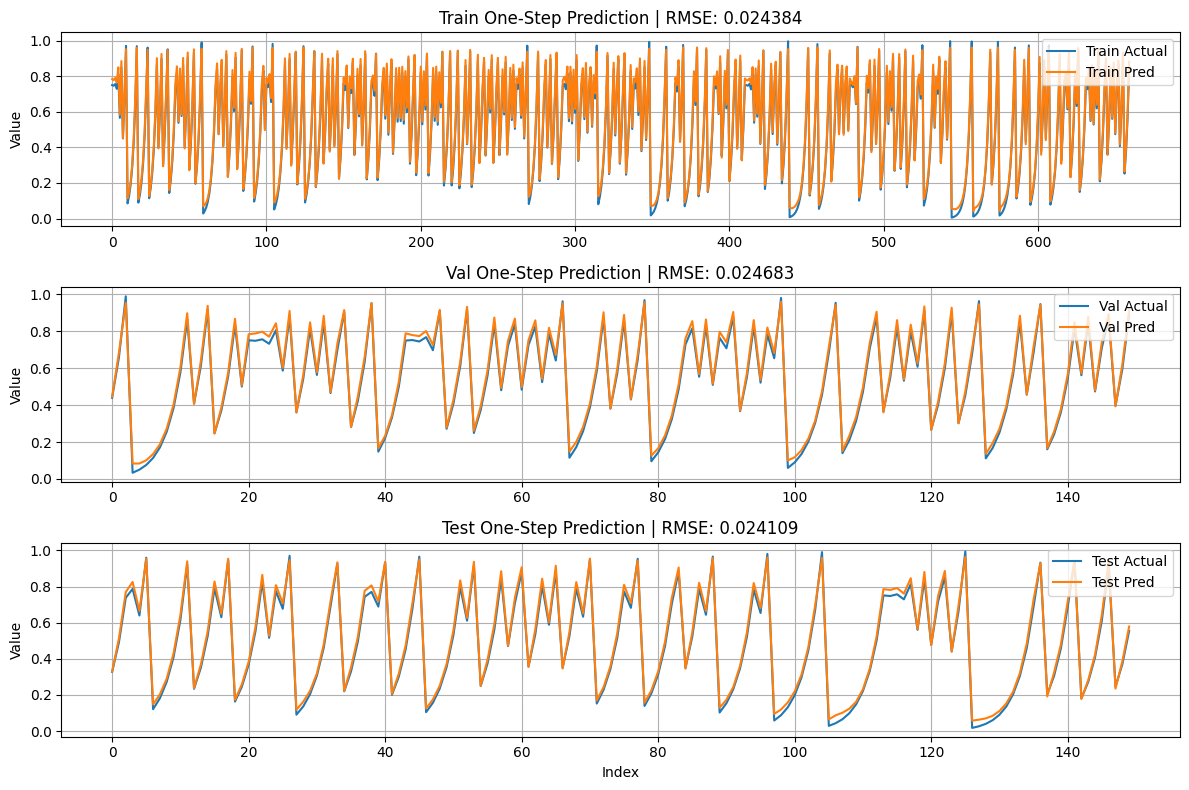

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# ============== DEVICE ==============
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============== DATA UTILS ==============

def load_tent_series(csv_path, column_name=None):
    """
    Load a 1D tent map series from CSV.

    - Drops common index/step columns like 'step'.
    - If column_name is given, use that numeric column.
    - Else: if exactly one numeric column remains, use it.
    - Else: use the first remaining numeric column (no extra warning here,
      assuming 'step' was the only confusing one).
    """
    df = pd.read_csv(csv_path)

    # Drop obvious non-signal numeric columns if present
    drop_candidates = ["step", "Step", "time", "Time", "index", "Index"]
    for col in drop_candidates:
        if col in df.columns:
            df = df.drop(columns=[col])

    num_df = df.select_dtypes(include=[np.number])

    if num_df.shape[1] == 0:
        raise ValueError("No numeric columns found in CSV after dropping step/time/index.")

    if column_name is not None:
        if column_name not in num_df.columns:
            raise ValueError(
                f"Requested column '{column_name}' not found among numeric columns: {list(num_df.columns)}"
            )
        data = num_df[column_name].values.astype(np.float32)
    else:
        # If there's only one numeric col left, it's unambiguous
        # If there are multiple, we take the first as the tent map series
        data = num_df.iloc[:, 0].values.astype(np.float32)

    return data


def make_supervised_1d(data, seq_len):
    """
    Accepts data as shape (T,) or (T,1).
    Returns:
        X: (N, seq_len, 1)
        y: (N, 1)
    where X[i] = data[i : i+seq_len], y[i] = data[i+seq_len].
    """
    data = np.asarray(data, dtype=np.float32)

    if data.ndim == 2 and data.shape[1] == 1:
        data = data[:, 0]

    T = data.shape[0]
    N = T - seq_len
    if N <= 0:
        raise ValueError(f"Sequence length {seq_len} too long for series of length {T}")

    X = np.zeros((N, seq_len, 1), dtype=np.float32)
    y = np.zeros((N, 1), dtype=np.float32)

    for i in range(N):
        X[i, :, 0] = data[i:i + seq_len]
        y[i, 0] = data[i + seq_len]

    return X, y


def prepare_loaders_1d(
    data,
    seq_len=40,
    split=0.7,
    val_split=0.15,
    batch_size=64
):
    """
    Prepare train/val/test loaders for 1D series.

    - Uses only train segment to fit scaler.
    - Builds supervised (seq -> next) pairs on scaled data.
    - Splits indices in pair-space according to raw split locations.
    """
    data = np.asarray(data, dtype=np.float32)
    T = len(data)
    if T <= seq_len + 5:
        raise ValueError("Time series too short for given seq_len.")

    # Raw index splits
    train_end_raw = int(T * split)
    val_end_raw = int(T * (split + val_split))
    train_end_raw = max(train_end_raw, seq_len + 1)
    val_end_raw = max(val_end_raw, train_end_raw + 1)

    # Scale using train region only
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data[:train_end_raw].reshape(-1, 1))
    data_scaled = scaler.transform(data.reshape(-1, 1))

    # Supervised pairs from scaled data
    X, y = make_supervised_1d(data_scaled, seq_len)
    N = X.shape[0]

    # Map raw splits into pair indices
    train_N = max(train_end_raw - seq_len, 1)
    val_N = max(val_end_raw - seq_len, train_N + 1)
    train_N = min(train_N, N - 2)
    val_N = min(val_N, N - 1)

    X_train = X[:train_N]
    y_train = y[:train_N]

    X_val = X[train_N:val_N]
    y_val = y[train_N:val_N]

    X_test = X[val_N:]
    y_test = y[val_N:]

    if len(X_val) == 0 or len(X_test) == 0:
        raise ValueError(
            f"Not enough data for val/test with seq_len={seq_len}, split={split}, val_split={val_split}."
        )

    train_ds = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32, device=device),
        torch.tensor(y_train, dtype=torch.float32, device=device),
    )
    val_ds = TensorDataset(
        torch.tensor(X_val, dtype=torch.float32, device=device),
        torch.tensor(y_val, dtype=torch.float32, device=device),
    )
    test_ds = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32, device=device),
        torch.tensor(y_test, dtype=torch.float32, device=device),
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

    return (
        train_loader,
        val_loader,
        test_loader,
        scaler,
        X_train,
        y_train,
        X_val,
        y_val,
        X_test,
        y_test,
    )


# ============== TRANSFORMER (SELF-ATTENTION) ==============

class PositionalEncodingBatchFirst(nn.Module):
    """
    Standard sinusoidal positional encoding for batch_first tensors.
    Expects input of shape (B, L, d_model).
    """

    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Shape: (1, max_len, d_model) to broadcast over batch
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        """
        x: (B, L, d_model)
        """
        L = x.size(1)
        return x + self.pe[:, :L, :]


class TentTransformer(nn.Module):
    """
    Self-attention model for 1D tent map one-step prediction.

    Input:  (B, L, 1)  scaled values
    Output: (B, 1)     next value (scaled)
    """

    def __init__(
        self,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.1,
        pooling="last",
    ):
        super().__init__()
        self.d_model = d_model
        self.pooling = pooling

        self.input_proj = nn.Linear(1, d_model)
        self.pos_encoding = PositionalEncodingBatchFirst(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,  # (B, L, E)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        x: (B, L, 1)
        """
        h = self.input_proj(x)          # (B, L, d_model)
        h = self.pos_encoding(h)        # (B, L, d_model)
        h = self.encoder(h)             # (B, L, d_model)

        if self.pooling == "mean":
            rep = h.mean(dim=1)         # (B, d_model)
        else:
            rep = h[:, -1, :]           # (B, d_model) last step

        y = self.fc_out(rep)            # (B, 1)
        return y


# ============== TRAIN / EVAL / PLOT ==============

def train_transformer(model, train_loader, val_loader, epochs=15, lr=1e-3):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for ep in range(1, epochs + 1):
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            opt.zero_grad()
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            total += loss.item() * xb.size(0)
        train_loss = total / len(train_loader.dataset)

        model.eval()
        val_total = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                yhat = model(xb)
                loss = loss_fn(yhat, yb)
                val_total += loss.item() * xb.size(0)
        val_loss = val_total / max(1, len(val_loader.dataset))

        print(f"Epoch {ep:02d} | train {train_loss:.6f} | val {val_loss:.6f}")

    return model


def evaluate_rmse_1d(model, X, y, scaler):
    """
    Evaluate one-step RMSE and return inverse-transformed series.

    X: (N, L, 1) scaled
    y: (N, 1) scaled
    """
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X, dtype=torch.float32, device=device)
        pred_scaled = model(X_t).cpu().numpy()

    true_inv = scaler.inverse_transform(y)
    pred_inv = scaler.inverse_transform(pred_scaled)

    true_series = true_inv.squeeze(-1)
    pred_series = pred_inv.squeeze(-1)

    rmse = float(np.sqrt(np.mean((pred_series - true_series) ** 2)))
    return true_series, pred_series, rmse


def plot_predictions(
    train_true, train_pred,
    val_true, val_pred,
    test_true, test_pred,
    train_rmse, val_rmse, test_rmse
):
    """
    Plot the FULL one-step prediction time series:
    train, val, test actual vs predicted.
    """
    plt.figure(figsize=(12, 8))

    # Train
    plt.subplot(3, 1, 1)
    plt.plot(train_true, label="Train Actual")
    plt.plot(train_pred, label="Train Pred")
    plt.title(f"Train One-Step Prediction | RMSE: {train_rmse:.6f}")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend(loc="upper right")

    # Val
    plt.subplot(3, 1, 2)
    plt.plot(val_true, label="Val Actual")
    plt.plot(val_pred, label="Val Pred")
    plt.title(f"Val One-Step Prediction | RMSE: {val_rmse:.6f}")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend(loc="upper right")

    # Test
    plt.subplot(3, 1, 3)
    plt.plot(test_true, label="Test Actual")
    plt.plot(test_pred, label="Test Pred")
    plt.title(f"Test One-Step Prediction | RMSE: {test_rmse:.6f}")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


# ============== MAIN ==============

if __name__ == "__main__":
    # Point this to your 1D tent map CSV
    csv_path = "tent_long1.csv"

    if not os.path.exists(csv_path):
        print("CSV not found:", csv_path)
        raise SystemExit(1)

    data = load_tent_series(csv_path, column_name=None)

    seq_len = 40  # tune as required

    (
        train_loader,
        val_loader,
        test_loader,
        scaler,
        X_train,
        y_train,
        X_val,
        y_val,
        X_test,
        y_test,
    ) = prepare_loaders_1d(
        data,
        seq_len=seq_len,
        split=0.7,
        val_split=0.15,
        batch_size=64,
    )

    model = TentTransformer(
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.1,
        pooling="last",   # or "mean"
    )

    model = train_transformer(model, train_loader, val_loader, epochs=15, lr=1e-3)

    train_true, train_pred, train_rmse = evaluate_rmse_1d(model, X_train, y_train, scaler)
    val_true, val_pred, val_rmse = evaluate_rmse_1d(model, X_val, y_val, scaler)
    test_true, test_pred, test_rmse = evaluate_rmse_1d(model, X_test, y_test, scaler)

    print(f"RMSE Train: {train_rmse:.6f}")
    print(f"RMSE Val:   {val_rmse:.6f}")
    print(f"RMSE Test:  {test_rmse:.6f}")

    plot_predictions(
        train_true,
        train_pred,
        val_true,
        val_pred,
        test_true,
        test_pred,
        train_rmse,
        val_rmse,
        test_rmse,
    )


/tmp/ipython-input-589783100.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.fillna(method="ffill").fillna(method="bfill")


epoch 1 train 0.35893923152576795 val 0.2716170148054759
epoch 2 train 0.22283678343801788 val 0.14334023237228394
epoch 3 train 0.12463851191780784 val 0.11988726943731308
epoch 4 train 0.05469153505383116 val 0.03149146355688572
epoch 5 train 0.01991478136994622 val 0.013148809298872948
epoch 6 train 0.013208951010848537 val 0.01322438035160303
epoch 7 train 0.010256746591943682 val 0.015980182302494844
epoch 8 train 0.009062305454051857 val 0.0051517814832429095
epoch 9 train 0.007222637805071744 val 0.005993150485058625
epoch 10 train 0.006842509905497233 val 0.00702477116137743
Train: RMSE 0.043385517824384386 MAE 0.034574080258607864 MSE 0.001882303156889975 R2 0.9755837321281433
Val:   RMSE 0.04162088346226814 MAE 0.032739244401454926 MSE 0.0017322979401797056 R2 0.974456787109375
Test:  RMSE 0.04836253153971124 MAE 0.03876664862036705 MSE 0.0023389344569295645 R2 0.971159040927887
Model-based Lyapunov estimate: 12.087101936340332


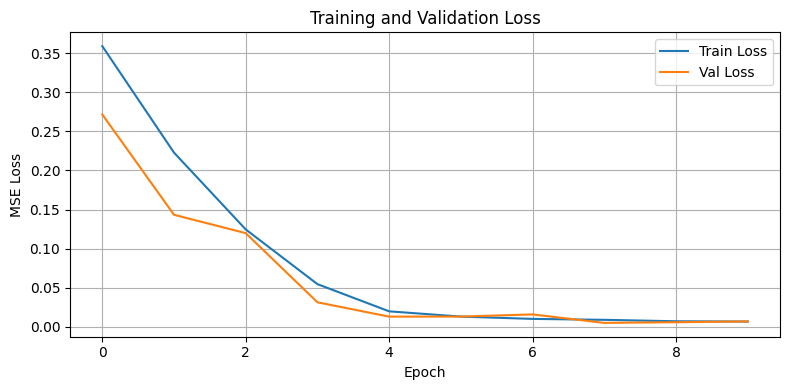

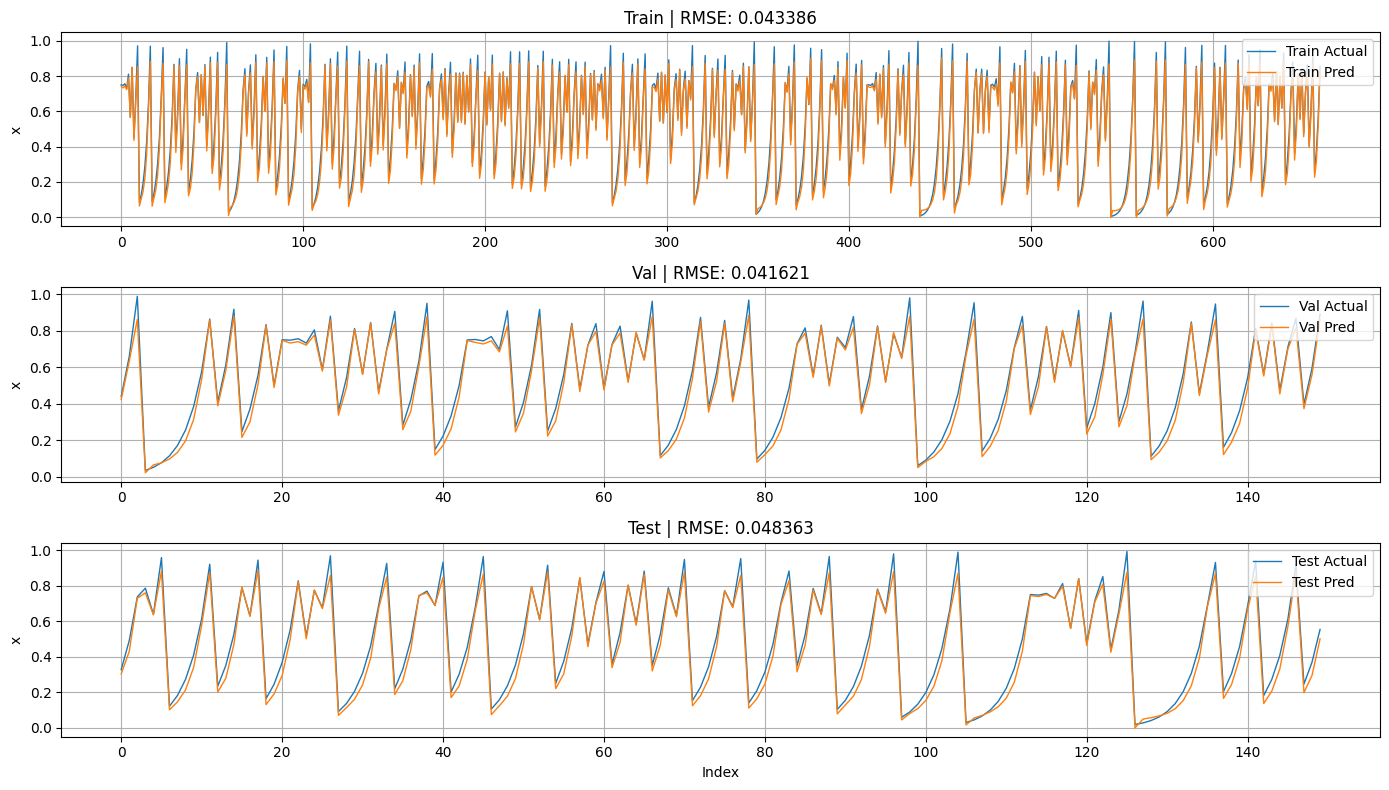

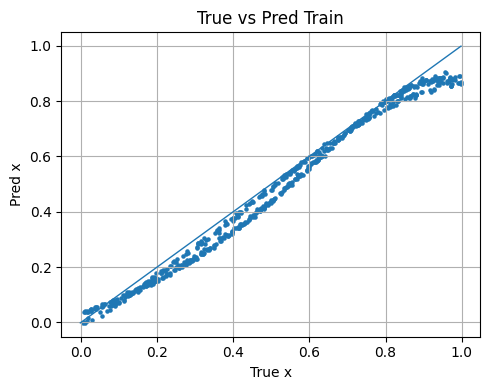

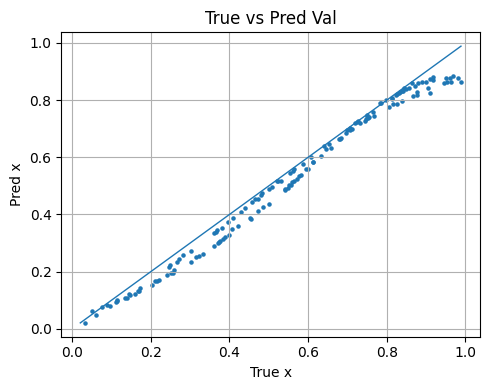

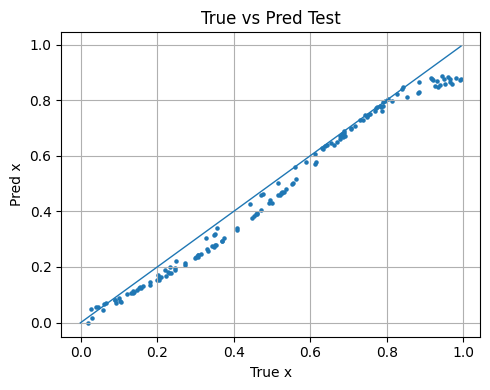

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_tent_series(csv_path):
    df = pd.read_csv(csv_path)
    if "step" in df.columns:
        df = df.drop(columns=["step"])
    if "x" in df.columns:
        s = df["x"]
    else:
        num_df = df.select_dtypes(include=[np.number])
        if num_df.shape[1] == 0:
            raise ValueError("No numeric column found in CSV.")
        s = num_df.iloc[:, 0]
    s = pd.to_numeric(s, errors="coerce")
    s = s.fillna(method="ffill").fillna(method="bfill")
    if s.isnull().any():
        s = s.fillna(s.mean())
    return s.to_numpy().astype(np.float32)


def make_supervised_1d(series, seq_len):
    T = len(series)
    N = T - seq_len
    X = np.zeros((N, seq_len, 1), dtype=np.float32)
    Y = np.zeros((N, 1), dtype=np.float32)
    for i in range(N):
        X[i, :, 0] = series[i:i + seq_len]
        Y[i, 0] = series[i + seq_len]
    return X, Y


def prepare_loaders_1d(series, seq_len=40, split=0.7, val_split=0.15, batch=64):
    T = len(series)
    train_end = int(T * split)
    val_end = int(T * (split + val_split))

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(series[:train_end].reshape(-1, 1))
    scaled = scaler.transform(series.reshape(-1, 1)).astype(np.float32).reshape(-1)

    X, Y = make_supervised_1d(scaled, seq_len)
    train_N = train_end - seq_len
    val_N = val_end - seq_len

    train_X_np = X[:train_N]
    train_Y_np = Y[:train_N]
    val_X_np = X[train_N:val_N]
    val_Y_np = Y[train_N:val_N]
    test_X_np = X[val_N:]
    test_Y_np = Y[val_N:]

    train_ds = TensorDataset(
        torch.tensor(train_X_np, dtype=torch.float32, device=device),
        torch.tensor(train_Y_np, dtype=torch.float32, device=device)
    )
    val_ds = TensorDataset(
        torch.tensor(val_X_np, dtype=torch.float32, device=device),
        torch.tensor(val_Y_np, dtype=torch.float32, device=device)
    )
    test_ds = TensorDataset(
        torch.tensor(test_X_np, dtype=torch.float32, device=device),
        torch.tensor(test_Y_np, dtype=torch.float32, device=device)
    )

    train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=batch, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_ds, batch_size=batch, shuffle=False, drop_last=False)

    data_scaled = scaled.reshape(-1, 1)
    return (
        train_loader,
        val_loader,
        test_loader,
        scaler,
        train_X_np,
        train_Y_np,
        val_X_np,
        val_Y_np,
        test_X_np,
        test_Y_np,
        data_scaled
    )


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]


class TransformerForecast(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.0):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, input_size)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        enc = self.encoder(x)
        last = enc[:, -1, :]
        y = self.fc_out(last)
        return y


def train_once(model, train_loader, val_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_losses = []
    val_losses = []

    for ep in range(epochs):
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            opt.zero_grad()
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            total += loss.item() * xb.size(0)
        avg_tr = total / len(train_loader.dataset)

        model.eval()
        tot_val = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                yhat = model(xb)
                l = loss_fn(yhat, yb)
                tot_val += l.item() * xb.size(0)
        avg_val = tot_val / max(1, len(val_loader.dataset))

        train_losses.append(avg_tr)
        val_losses.append(avg_val)
        print("epoch", ep + 1, "train", avg_tr, "val", avg_val)

    return model, train_losses, val_losses


def evaluate_all_metrics(model, X, Y, scaler):
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    with torch.no_grad():
        pred = model(X_t).cpu().numpy()

    true_inv = scaler.inverse_transform(Y)
    pred_inv = scaler.inverse_transform(pred)

    diff = pred_inv - true_inv
    mse = float(np.mean(diff ** 2))
    rmse = float(np.sqrt(mse))
    mae = float(np.mean(np.abs(diff)))
    denom = np.sum((true_inv - np.mean(true_inv)) ** 2)
    num = np.sum(diff ** 2)
    r2 = float(1.0 - num / (denom + 1e-12))

    return true_inv, pred_inv, rmse, mae, mse, r2


def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_ts_predictions(train_true, train_pred, val_true, val_pred, test_true, test_pred,
                        train_rmse, val_rmse, test_rmse):
    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=False)

    axes[0].plot(train_true[:, 0], linewidth=1, label="Train Actual")
    axes[0].plot(train_pred[:, 0], linewidth=1, label="Train Pred")
    axes[0].set_title(f"Train | RMSE: {train_rmse:.6f}")
    axes[0].set_ylabel("x")
    axes[0].grid(True)
    axes[0].legend(loc="upper right")

    axes[1].plot(val_true[:, 0], linewidth=1, label="Val Actual")
    axes[1].plot(val_pred[:, 0], linewidth=1, label="Val Pred")
    axes[1].set_title(f"Val | RMSE: {val_rmse:.6f}")
    axes[1].set_ylabel("x")
    axes[1].grid(True)
    axes[1].legend(loc="upper right")

    axes[2].plot(test_true[:, 0], linewidth=1, label="Test Actual")
    axes[2].plot(test_pred[:, 0], linewidth=1, label="Test Pred")
    axes[2].set_title(f"Test | RMSE: {test_rmse:.6f}")
    axes[2].set_xlabel("Index")
    axes[2].set_ylabel("x")
    axes[2].grid(True)
    axes[2].legend(loc="upper right")

    plt.tight_layout()
    plt.show()


def plot_true_vs_pred_scatter(true_inv, pred_inv, title_suffix=""):
    plt.figure(figsize=(5, 4))
    plt.scatter(true_inv[:, 0], pred_inv[:, 0], s=5)
    lo = min(true_inv[:, 0].min(), pred_inv[:, 0].min())
    hi = max(true_inv[:, 0].max(), pred_inv[:, 0].max())
    plt.plot([lo, hi], [lo, hi], linewidth=1)
    plt.xlabel("True x")
    plt.ylabel("Pred x")
    plt.title(f"True vs Pred {title_suffix}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def compute_lyapunov(model, data_scaled, scaler, seq_len, steps=200, eps=1e-5):
    model.eval()
    T = data_scaled.shape[0]
    if T <= seq_len + steps + 2:
        steps = max(10, T - seq_len - 2)

    x0 = data_scaled[:seq_len].copy()
    rng = np.random.RandomState(0)
    delta = rng.randn(*x0.shape)
    delta = eps * delta / (np.linalg.norm(delta) + 1e-12)
    x1 = x0 + delta

    with torch.no_grad():
        y0 = model(torch.tensor(x0[np.newaxis, :, :], dtype=torch.float32, device=device)).cpu().numpy()[0]
        y1 = model(torch.tensor(x1[np.newaxis, :, :], dtype=torch.float32, device=device)).cpu().numpy()[0]

    y0_inv = scaler.inverse_transform(y0.reshape(1, -1))[0]
    y1_inv = scaler.inverse_transform(y1.reshape(1, -1))[0]
    d0 = np.linalg.norm(y1_inv - y0_inv) + 1e-12

    s = 0.0
    x0_seq = x0.copy()
    x1_seq = x1.copy()

    for _ in range(steps):
        with torch.no_grad():
            y0 = model(torch.tensor(x0_seq[np.newaxis, :, :], dtype=torch.float32, device=device)).cpu().numpy()[0]
            y1 = model(torch.tensor(x1_seq[np.newaxis, :, :], dtype=torch.float32, device=device)).cpu().numpy()[0]

        y0_inv = scaler.inverse_transform(y0.reshape(1, -1))[0]
        y1_inv = scaler.inverse_transform(y1.reshape(1, -1))[0]
        d = np.linalg.norm(y1_inv - y0_inv) + 1e-12
        s += np.log(d / d0)

        diff = x1_seq - x0_seq
        norm_diff = np.linalg.norm(diff) + 1e-12
        diff = diff / norm_diff
        x1_seq = x0_seq + eps * diff

        x0_seq = np.concatenate([x0_seq[1:], y0.reshape(1, 1)], axis=0)
        x1_seq = np.concatenate([x1_seq[1:], y1.reshape(1, 1)], axis=0)

    lyap = s / steps
    return float(lyap)


if __name__ == "__main__":
    csv_path = "tent_long1.csv"
    if not os.path.exists(csv_path):
        print("csv not found")
        raise SystemExit(1)

    series = load_tent_series(csv_path)

    seq_len = 40
    batch_size = 64
    epochs = 10

    (
        train_loader,
        val_loader,
        test_loader,
        scaler,
        Xtr,
        Ytr,
        Xval,
        Yval,
        Xte,
        Yte,
        data_scaled
    ) = prepare_loaders_1d(
        series,
        seq_len=seq_len,
        split=0.7,
        val_split=0.15,
        batch=batch_size,
    )

    model = TransformerForecast(
        input_size=1,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.0,
    )

    model, train_losses, val_losses = train_once(
        model,
        train_loader,
        val_loader,
        epochs=epochs,
        lr=1e-3,
    )

    train_true, train_pred, train_rmse, train_mae, train_mse, train_r2 = evaluate_all_metrics(model, Xtr, Ytr, scaler)
    val_true, val_pred, val_rmse, val_mae, val_mse, val_r2 = evaluate_all_metrics(model, Xval, Yval, scaler)
    test_true, test_pred, test_rmse, test_mae, test_mse, test_r2 = evaluate_all_metrics(model, Xte, Yte, scaler)

    print("Train: RMSE", train_rmse, "MAE", train_mae, "MSE", train_mse, "R2", train_r2)
    print("Val:   RMSE", val_rmse, "MAE", val_mae, "MSE", val_mse, "R2", val_r2)
    print("Test:  RMSE", test_rmse, "MAE", test_mae, "MSE", test_mse, "R2", test_r2)

    lyap = compute_lyapunov(model, data_scaled, scaler, seq_len=seq_len, steps=100, eps=1e-5)
    print("Model-based Lyapunov estimate:", lyap)

    plot_loss_curves(train_losses, val_losses)

    plot_ts_predictions(
        train_true=train_true,
        train_pred=train_pred,
        val_true=val_true,
        val_pred=val_pred,
        test_true=test_true,
        test_pred=test_pred,
        train_rmse=train_rmse,
        val_rmse=val_rmse,
        test_rmse=test_rmse,
    )

    plot_true_vs_pred_scatter(train_true, train_pred, title_suffix="Train")
    plot_true_vs_pred_scatter(val_true, val_pred, title_suffix="Val")
    plot_true_vs_pred_scatter(test_true, test_pred, title_suffix="Test")
